## Supervised Learning
## Project: Finding Donors for *CharityML*

## Business understanding

The goal of this project is to accurately predict whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with

In this analysis, I will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. I will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. 

## Data Understanding


In [64]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import fbeta_score,accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [4]:
# Load the Census dataset
data = pd.read_csv("census.csv")
data.head(n=5)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [6]:
print('Shape of the data is :',data.shape)
print('\nName of the columns are :\n',data.columns.tolist())

Shape of the data is : (45222, 14)

Name of the columns are :
 ['age', 'workclass', 'education_level', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


Income is the variable we would like to predict. Let's look at the distribution

In [7]:
print(type(data['income'][0]))
print(data['income'].value_counts())

<class 'str'>
<=50K    34014
>50K     11208
Name: income, dtype: int64


In [5]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


Out of 14 variables, only 5 are numerical. This means the rest are categorical variables. Let's look at the numerical variable first. Many of the models require normally distributed data and presence of outlier might affect the model. In this step, I will look at the histogram of all the numerical features

In [8]:
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [12]:
def plot_hist(col):
    '''
    Input -- A numerical column
    output-- A histogram of the input values
    '''
    plt.hist(data[col],rwidth=.8)
    plt.title(col,size=14)
    plt.show()
    

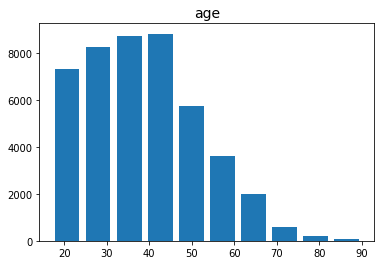

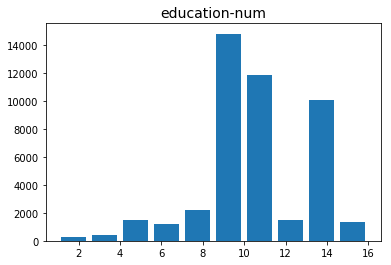

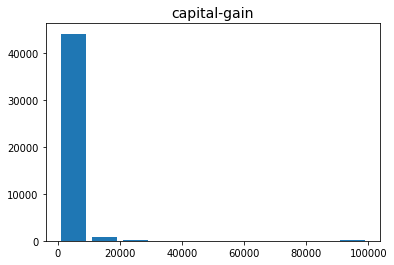

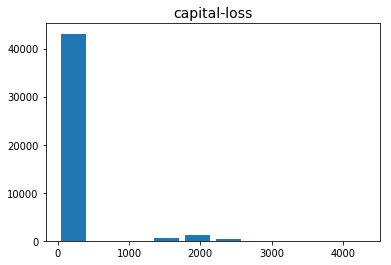

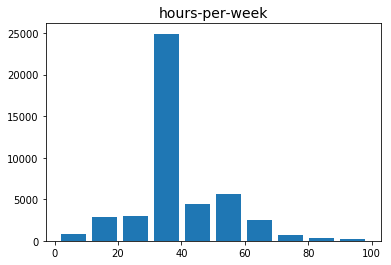

In [13]:
for col in numerical:
    plot_hist(col)
    

**Capital-loss and Capital-gain column are highly skewed. From the data summary shown earlier, It is clear that most of the values in the column are zeroes. Making a log-transformation might bring the values together**

**Histogram of log transformed values are shown below. One is added to all the values to remove the zeroes**


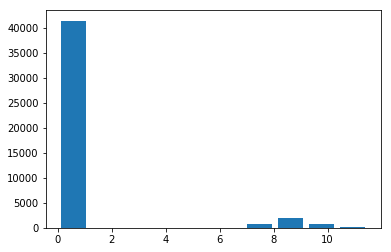

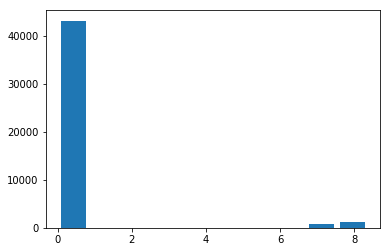

In [25]:
plt.hist(np.log(data['capital-gain']+1),rwidth=.8)
plt.show()
plt.hist(np.log(data['capital-loss']+1),rwidth=.8)
plt.show()

**Explore the categorical features**

In [26]:
categorical=[col for col in data.columns if col not in numerical+['income']]
print(categorical)

['workclass', 'education_level', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [28]:
def plot_bar(col):
    '''
    Input - A categorical column
    Output- A barplot
    '''
    val=data[col].value_counts()
    plt.barh(val.index,val)
    plt.title(col)
    plt.show()

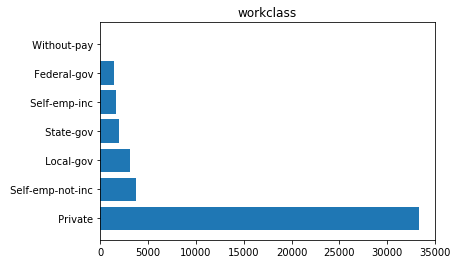

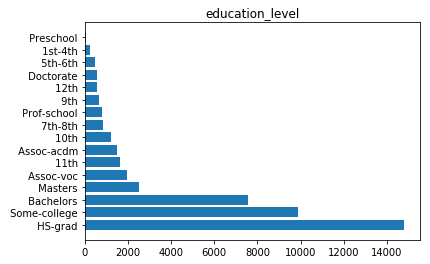

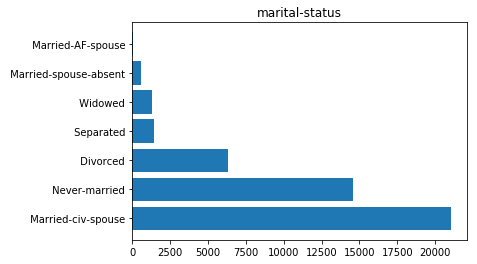

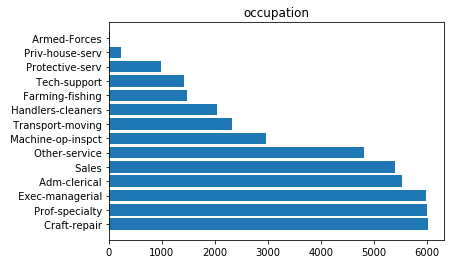

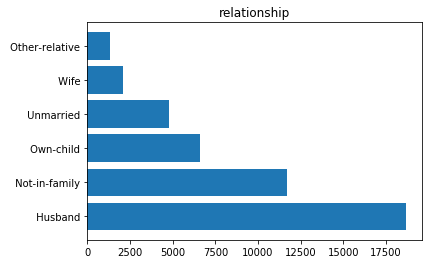

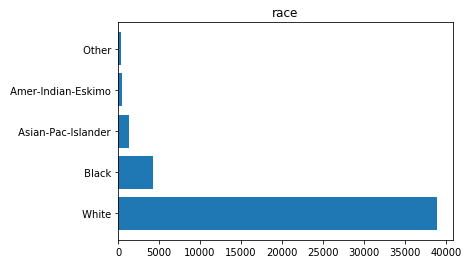

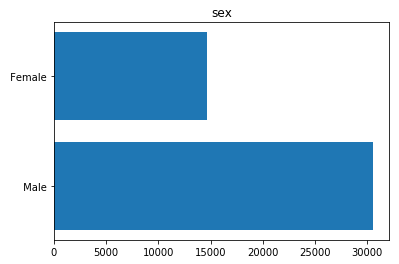

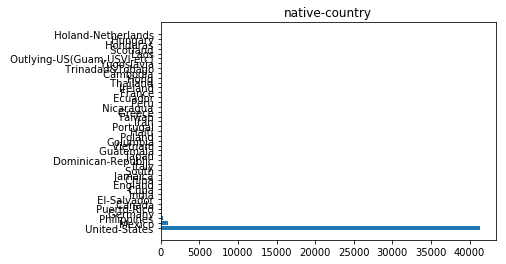

In [29]:
for col in categorical:
    plot_bar(col)


---
**Notes**

Most of the variables have average number of categories. 
But variable 'native-country' has many levels but the frequeny of those levels are too small
I may have to remove some of the levels !



----
## Data Preparation

In this process, I will normalize the data and remove of the levels in categorical variables

Are they any null values in the data ?

In [31]:
print(data.isnull().sum(axis=0))

age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


Fortunately, data is cleaned before and no null values are present

Now, convert the predictor variable into 0's and 1's

In [32]:
income = [0 if x=='<=50K' else 1 for x in data['income']]
data['income']=income

Log transform the 'capital-gain' and 'capital-loss' variables

In [33]:
data['capital-gain']=np.log(data['capital-gain']+1)
data['capital-loss']=np.log(data['capital-loss']+1)

In order to remove some of the levels in categorical features, I will look at their relationship with income variable

In [35]:
for cat in categorical:
    print(data.groupby(cat)['income'].mean())
    print("\n")

workclass
 Federal-gov         0.390469
 Local-gov           0.295161
 Private             0.217702
 Self-emp-inc        0.554070
 Self-emp-not-inc    0.278978
 State-gov           0.267215
 Without-pay         0.095238
Name: income, dtype: float64


education_level
 10th            0.067048
 11th            0.054972
 12th            0.074523
 1st-4th         0.036036
 5th-6th         0.048998
 7th-8th         0.066829
 9th             0.056213
 Assoc-acdm      0.264101
 Assoc-voc       0.257274
 Bachelors       0.419815
 Doctorate       0.733456
 HS-grad         0.163431
 Masters         0.554097
 Preschool       0.013889
 Prof-school     0.754140
 Some-college    0.201030
Name: income, dtype: float64


marital-status
 Divorced                 0.104018
 Married-AF-spouse        0.437500
 Married-civ-spouse       0.454239
 Married-spouse-absent    0.097826
 Never-married            0.048020
 Separated                0.070163
 Widowed                  0.094753
Name: income, dtype: float

In the education-level variable, all the levels at the school education have income close to 0. It may be a good idea to combine them

In [36]:
data['education_level'].unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' 7th-8th', ' Doctorate',
       ' Assoc-voc', ' Prof-school', ' 5th-6th', ' 10th', ' Preschool',
       ' 12th', ' 1st-4th'], dtype=object)

In [37]:
# Create a list of levels to combine
school_list=[' 11th',' 9th',' 7th-8th',' 5th-6th', ' 10th', ' Preschool',
       ' 12th', ' 1st-4th']

In [38]:
# Combine the levels & check the result
education_level_new=[' School' if x in school_list else x for x in data['education_level']]
pd.Series(education_level_new).value_counts()

 HS-grad         14783
 Some-college     9899
 Bachelors        7570
 School           5661
 Masters          2514
 Assoc-voc        1959
 Assoc-acdm       1507
 Prof-school       785
 Doctorate         544
dtype: int64

In [39]:
# Replace the education-level
data['education_level']=education_level_new

In [41]:
# Remove some of the countries with low counts
data['native-country'].value_counts()

 United-States                 41292
 Mexico                          903
 Philippines                     283
 Germany                         193
 Puerto-Rico                     175
 Canada                          163
 El-Salvador                     147
 India                           147
 Cuba                            133
 England                         119
 China                           113
 Jamaica                         103
 South                           101
 Italy                           100
 Dominican-Republic               97
 Japan                            89
 Guatemala                        86
 Vietnam                          83
 Columbia                         82
 Poland                           81
 Haiti                            69
 Portugal                         62
 Iran                             56
 Taiwan                           55
 Greece                           49
 Nicaragua                        48
 Peru                             45
 

In [42]:
# Change the levels
native_country_new=[' Non-US' if x!=' United-States' else x for x in data['native-country']]
pd.Series(native_country_new).value_counts()

 United-States    41292
 Non-US            3930
dtype: int64

In [43]:
data['native-country']=native_country_new

The features 'education_level' and 'education_num' may be similar. In that case, I could remove one of them

In [44]:
# This would give the mean of education-num on different levels of education_level
data.groupby('education_level')['education-num'].mean()

education_level
 Assoc-acdm      12.000000
 Assoc-voc       11.000000
 Bachelors       13.000000
 Doctorate       16.000000
 HS-grad          9.000000
 Masters         14.000000
 Prof-school     15.000000
 School           5.621268
 Some-college    10.000000
Name: education-num, dtype: float64

They are proportional to each other. Higher education is associated with higher values of education-num

In [45]:
# Let the drop the education-num feature

data.drop(['education-num'],axis=1,inplace=True)

In [46]:
data.head()

,age,workclass,education_level,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,7.684784,0.0,40.0,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,13.0,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,40.0,United-States,0
3,53,Private,School,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,40.0,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,40.0,Non-US,0


---
#### Normalizing numerical features & transforming categorical features

It is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution however, normalization ensures that each feature is treated equally when applying supervised learners.

For furuther analysis, we require the input to be numeric, which requires that non-numeric features (called categorical variables) be converted. Here, I will use one-hot encoding scheme. One-hot encoding creates a "dummy" variable for each possible category of each non-numeric feature

In [49]:
# Initialize a Minmaxscaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
data[numerical] = scaler.fit_transform(np.float64(data[numerical]))


In [50]:
data.describe()

,age,capital-gain,capital-loss,hours-per-week,income
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,0.295177,0.064342,0.042423,0.407531,0.247844
std,0.181067,0.214240,0.190454,0.122526,0.431766
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.000000,0.000000,0.397959,0.000000
50%,0.273973,0.000000,0.000000,0.397959,0.000000
75%,0.410959,0.000000,0.000000,0.448980,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
data_final = pd.get_dummies(data,columns=categorical)

In [54]:
print("Shape of the data is :",data_final.shape)

Shape of the data is : (45222, 57)


In [55]:
print(data_final.columns)

Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'income',
       'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'education_level_ Assoc-acdm', 'education_level_ Assoc-voc',
       'education_level_ Bachelors', 'education_level_ Doctorate',
       'education_level_ HS-grad', 'education_level_ Masters',
       'education_level_ Prof-school', 'education_level_ School',
       'education_level_ Some-college', 'marital-status_ Divorced',
       'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separated',
       'marital-status_ Widowed', 'occupation_ Adm-clerical',
       'occupation_ Armed-Forces', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fis

### Shuffle and Split Data


In [56]:
y=data_final['income']
X=data_final.drop(['income'],axis=1)

In [57]:
print(X.shape)
print(y.shape)

(45222, 56)
(45222,)


In [59]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Model building

In this section, we will investigate four different algorithms, and determine which is best at modeling the data. In order to establish a baseline model, we will build a fourth algorithm known as a *naive predictor*.

### Metrics and the Naive Predictor

*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).



#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`


###  Naive Predictor Performace

A naive predictor would be a model that always predict 1. Then, our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative predictions. Let's calculate the metrics for this model

In [60]:

TP=np.sum(y_train)
FP=len(y_train)-TP
TN=0
FN=0


accuracy = (TP+TN)/(len(y_train))
recall = TP/(TP+FN)
precision = TP/(TP+FP)

fscore = (1+0.5**2)*(precision*recall)/(((.5**2)*precision)+recall)

print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))
print("Precision and Recall are :",(precision,recall))

Naive Predictor: [Accuracy score: 0.2489, F-score: 0.2929]
Precision and Recall are : (0.2488597727838129, 1.0)


---
**Thoughts on Model Selection**


This is a high dimensional data set (57 features) with nearly 50k samples. Very simpler models Naive Bayes won't work. I prefer to use low bias/ high variance models

Logistic Regression

The model is fast to train, it is highly interpretable. It perform well when there is a linear relationship between the predictor and response variables.It perform badly when predictor variables are correlated. As it assumes a linear relationship, it perform poorly when there is complex relationship between predictors and response variables. As we nothing about the data, Logistic Regression will be a good starting point. As the number of sample are high, a faster algorithm would help. As this is more interpretable,important features can be used to distinguish and target high net-worth individuals easily.

Decision Trees

It is highly interpretable. It can provide multiple scenarios for the same decision. It perform well with larger datasets .Prone to overfitting. Small changes in data could change the model. One disdvantages is that it won't generalize well with small datasets. As our dataset is sufficiently high and nature of relationship between variable are unknow, decision trees could be better option. By suitable prunning, we can limit the complexity of the trees

Random Forest Classifier

This model could solve the overfitting problem of decision trees

###  Model selection

In [61]:
# We will be building model with many subset of data

samples_100 = len(y_train)
samples_10 = int(0.1*len(y_train))
samples_1 = int(0.01*len(y_train))

In [63]:
clf_A = LogisticRegression(random_state=5,solver='liblinear')
clf_B = DecisionTreeClassifier(random_state=10)
clf_C = RandomForestClassifier(n_estimators=50,random_state=15)
models=[clf_A,clf_B,clf_C]
model_names=['LogisticRegression','DecisionTree','RandomForest']
i=0
for model in models:
    results_df=pd.DataFrame(columns=['size','time','f_train','f_test'])
    for sample in [samples_1,samples_10,samples_100]:
        clf = model
        start_t=time()
        clf.fit(X_train[0:sample],y_train[0:sample])
        end_t=time()
        y_train_pred=clf.predict(X_train[0:sample])
        y_test_pred=clf.predict(X_test)
#         print("Number of sample data used:",sample)
        fit_time=end_t-start_t
#         print("Fitting time :",fit_time)
        f_train=fbeta_score(y_train[0:sample],y_train_pred,beta=.5)
        f_test=fbeta_score(y_test,y_test_pred,beta=.5)
#         print('fbeta score on the training data :',f_train)
#         print('fbeta score on the test data :',f_test)
        results_df=results_df.append({'size':sample,'time':fit_time,'f_train':f_train,'f_test':f_test},ignore_index=True)
    print('Results for the {} model:'.format(model_names[i]))
    display(results_df)
    i+=1

Results for the LogisticRegression model:


,size,time,f_train,f_test
0,361.0,0.003690,0.746753,0.646357
1,3617.0,0.024709,0.688149,0.677618
2,36177.0,0.421184,0.692407,0.682314


Results for the DecisionTree model:


,size,time,f_train,f_test
0,361.0,0.003908,1.000000,0.567373
1,3617.0,0.035725,0.995294,0.593562
2,36177.0,0.427095,0.963062,0.627726


Results for the RandomForest model:


,size,time,f_train,f_test
0,361.0,0.091298,1.000000,0.623804
1,3617.0,0.240851,0.992045,0.670764
2,36177.0,2.959155,0.949739,0.678547


----
### Improving Results

In this final section, I will choose one model from previous three. I will then perform a grid search optimization for the model over the entire training set by tuning over many different parameters

**Best Model**

Logistic regression is consistent results in terms of speed, accuracy and f-score. However,sample size doesn't have any impact on the performance metric. This shows it is high bias low variance model. As a result, chances of improving it using turning are small. On the other hand, Decision trees and Random Forest Classifier nearly overfit the data at the default values. However the adjusting the parameters performance can be improved. I prefer Random forest over Decision trees in that subsetting the data, only a small number of features can be used which will improve the performance. So I intend to proceeed with RandomForestClassifer


In [85]:
clf = RandomForestClassifier(random_state=50)
parameters = {'n_estimators':[100,200],'max_depth':[10,15,20],'max_features':[20,30,'auto']}
scorer = make_scorer(fbeta_score,beta=0.5)
grid_obj = GridSearchCV(clf,param_grid=parameters,scoring=scorer,cv=4)
grid_fit = grid_obj.fit(X_train,y_train)
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/Users/Vineeth/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8378
F-score on testing data: 0.6726

Optimized Model
------
Final accuracy score on the testing data: 0.8577
Final F-score on the testing data: 0.7288


In [95]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=30, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [82]:
fbeta_score(y_train, best_clf.predict(X_train), beta = 0.5)

0.7644853537755645

In [83]:
accuracy_score(y_train, best_clf.predict(X_train))

0.868479973463803

In [79]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}



clf = RandomForestClassifier(random_state=50)
scorer = make_scorer(fbeta_score,beta=0.5)
random_obj = RandomizedSearchCV(clf,param_distributions=random_grid,scoring=scorer,cv=5)
random_fit = random_obj.fit(X_train,y_train)
best_clf = random_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))



/Users/Vineeth/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8378
F-score on testing data: 0.6726

Optimized Model
------
Final accuracy score on the testing data: 0.8595
Final F-score on the testing data: 0.7369


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8378|      |   .8577
| F-score        |      .6726        |   .7288         |


----
### Feature Importance

Our primary objective was to predict the income of inviduals. We did this using several features. It is even better if we can select few important features that can quickly identify individual we want. Using a small subset of features also simplify our understanding

scikit-learn  has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier. We will use this attribute to determine the top 5 most important features for the census dataset

In [97]:
feature_importance=pd.DataFrame({'features':X_train.columns,'importance':best_clf.feature_importances_})
feature_importance=feature_importance.sort_values(by=['importance'],ascending=False)
feature_importance[0:10]

,features,importance
22,marital-status_ Married-civ-spouse,0.251555
1,capital-gain,0.220129
41,relationship_ Husband,0.102074
2,capital-loss,0.070336
0,age,0.052818
18,education_level_ School,0.040882
3,hours-per-week,0.036337
13,education_level_ Bachelors,0.032315
15,education_level_ HS-grad,0.031278
30,occupation_ Exec-managerial,0.027413


### Feature Selection

How does our perform if we use only 10 most important features.  With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics

In [106]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[feature_importance['features'][0:10].tolist()]
X_test_reduced = X_test[feature_importance['features'][0:10].tolist()]


best_clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=50, verbose=0, warm_start=False)


# Train on the "best" model found from grid search earlier
clf = best_clf.fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8577
F-score on testing data: 0.7288

Final Model trained on reduced data
------
Accuracy on testing data: 0.8491
F-score on testing data: 0.6998


**Accuracy and f-score are still good with the reduced features dataset**

In [ ]:
!!jupyter nbconvert *.ipynb